# <center> Are Haters Just Hating?: A Statistical Analysis of CSGO Pro Gamers
<center> Sam Felsenfeld, Cindy Jia, Mark Levin </center>

## <center> Introduction</center>

Public opinion can often be a misrepresentation of the actual performance of public figures. In this analysis, we explore the case of CSGO e-sports athletes, and determine whether the public perception that a player is either at the top of their game or on their way out actually correlated with their typical performance, or more likely influenced by a single event.

## <center> Data Collection


In [4]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import requests
from bs4 import BeautifulSoup
import re
from requests_html import AsyncHTMLSession

In [5]:
### Create a list of world rankings
url = "https://pro.eslgaming.com/worldranking/csgo/rankingshistory/"

### Get page and render javascript
session = AsyncHTMLSession()
r = await session.get(url)
await r.html.arender()


### Start scraping page (not finished)
bs = BeautifulSoup(r.html.html)
for el in bs.find_all("div", class_="small"):
    print(el)

[INFO] Starting Chromium download.
100%|██████████| 86.8M/86.8M [00:05<00:00, 14.5Mb/s]
[INFO] Beginning extraction
[INFO] Chromium extracted to: /Users/marklevin/Library/Application Support/pyppeteer/local-chromium/588429


In [6]:
### Get a list of awpers from liquipedia
### Getting awpers
urls = ["https://liquipedia.net/counterstrike/Category:AWPers",
        "https://liquipedia.net/counterstrike/index.php?title=Category:AWPers&pagefrom=Galantis#mw-pages",
        "https://liquipedia.net/counterstrike/index.php?title=Category:AWPers&pagefrom=Powell#mw-pages"]

awpers = {"~~~~"} # Create a lookup table of awpers
for url in urls:
    res = requests.get(url)
    bs = BeautifulSoup(res.content)
    ### Toggle system to only get from first to last player on each page
    toggle = False
    for l in bs.find_all("a"):
        if "Ace" in l.get('href') or "/Galantis" in l.get('href') or "/Powell" in l.get('href'):
            toggle=True
        if toggle:
            s = l.get('href')[15:].lower()
            awpers.add(s) # Add base name
            if "_" in s:
                s = s[:s.find("_")] # add name with extra annotations removed
            awpers.add(s)
            s = re.sub(r'[^a-zA-Z0-9]', '', s)# Remove extra characters
            awpers.add(s)
        if "Gafolo" in l.get('href') or "Potei" in l.get('href') or "ZywOo" in l.get('href'):
            toggle=False

with open("awpers.json", 'w') as file:
    json.dump(list(awpers), file)

## <center> Data Processing

In [39]:
df = pd.read_csv("all games processed.csv", sep=',')
with open('awpers.json') as file:
    awpers = json.load(file)
df= df.drop('Unnamed: 0', axis=1)

# cleaning data and labeling awpers
df['rating'] = df['rating'].apply(lambda s: float(s.replace("*", "")))
df['Awper'] = df['player name'].apply(lambda s: s in awpers)
df.head()

,Date,Player team,Opponent,Map,kd,pm,rating,player name,kd ratio,rounds won,rounds lost,Total rounds,Awper
0,31/10/20,Golden Knights,Lyngby Vikings,nuke,17 - 21,-4,0.83,fitch,0.809524,13,16,29,False
1,31/10/20,Golden Knights,Lyngby Vikings,mrg,14 - 20,-6,0.77,fitch,0.700000,16,12,28,False
2,19/5/20,Syman,SG.pro,trn,8 - 20,-12,0.56,fitch,0.400000,13,16,29,False
3,19/5/20,Syman,SG.pro,mrg,11 - 18,-7,0.61,fitch,0.611111,10,16,26,False
4,18/5/20,Syman,LDLC,d2,13 - 19,-6,0.87,fitch,0.684211,11,16,27,False


In [40]:
players = df['player name'].unique()
teams = df['Player team'].unique()

In [41]:
df = df.assign(Date = pd.to_datetime(df['Date']))
df.sort_values('Date').head()

,Date,Player team,Opponent,Map,kd,pm,rating,player name,kd ratio,rounds won,rounds lost,Total rounds,Awper
380533,2012-01-11,dotpiXels,CPLAY,mrg,15 - 16,-1,0.87,legija,0.937500,16,6,22,False
474590,2012-01-11,gamed!de,iPLAY,trn,22 - 12,10,1.47,syrson,1.833333,16,7,23,True
469648,2012-01-11,ALTERNATE aTTaX,CPLAY,trn,15 - 12,3,0.96,krystal,1.250000,16,9,25,False
438636,2012-01-11,dotpiXels,CPLAY,mrg,32 - 13,19,2.19,tabsen,2.461538,16,6,22,False
485888,2012-01-12,BuyKey,ESC,inf,26 - 16,10,1.57,scream,1.625000,16,7,23,False


,Date,Player team,Opponent,Map,kd,pm,rating,player name,kd ratio,rounds won,rounds lost,Total rounds,Awper,standard rating
0,2020-10-31,Golden Knights,Lyngby Vikings,nuke,17 - 21,-4,0.83,fitch,0.809524,13,16,29,False,-0.745959
1,2020-10-31,Golden Knights,Lyngby Vikings,mrg,14 - 20,-6,0.77,fitch,0.700000,16,12,28,False,-0.937575
2,2020-05-19,Syman,SG.pro,trn,8 - 20,-12,0.56,fitch,0.400000,13,16,29,False,-1.608230
3,2020-05-19,Syman,SG.pro,mrg,11 - 18,-7,0.61,fitch,0.611111,10,16,26,False,-1.448550
4,2020-05-18,Syman,LDLC,d2,13 - 19,-6,0.87,fitch,0.684211,11,16,27,False,-0.618215


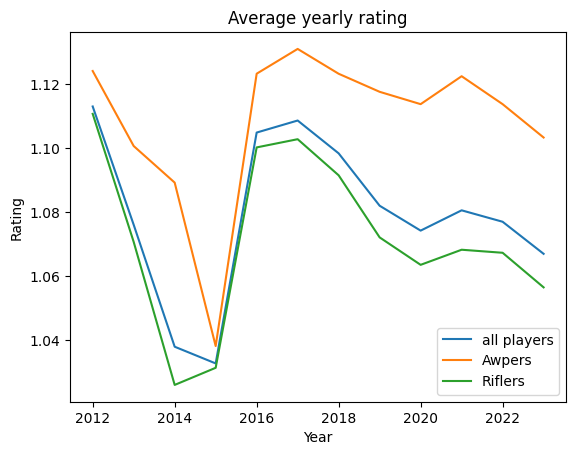

In [44]:
x = np.arange(2012, 2024)
y = []
y_awp = []
y_rifle = []

# determining mean performance per year and standardizing rating
for year in x:
    date_mask = (dt.datetime(year,1,1) < df['Date']) & (df['Date'] < dt.datetime(year,12,31))
    y.append(df[date_mask]['rating'].mean())
    mean_awp = df[date_mask & df['Awper']]['rating'].mean()
    y_awp.append(mean_awp)
    mean_rifle = df[date_mask & ~df['Awper']]['rating'].mean()
    y_rifle.append(mean_rifle)

    std_awp = df[date_mask & df['Awper']]['rating'].std()
    std_rifle = df[date_mask & ~df['Awper']]['rating'].std()
    
    df.loc[date_mask & df['Awper'],'standard rating'] = (df['rating']-mean_awp) / std_awp
    df.loc[date_mask & ~df['Awper'],'standard rating'] = (df['rating']-mean_rifle) / std_rifle

plt.plot(x,y,label = 'all players')
plt.plot(x,y_awp,label = 'Awpers')
plt.plot(x,y_rifle,label = 'Riflers')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Rating")
plt.title("Average yearly rating")
df.head()